# Austin Animal Shelter
The goal of this project is to determine the important factors that lead to an outcome (adoption, transfer, return to owner, death, euthanasia) of an animal in the shelter and to make a model that predicts outcomes based on these features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


# Load  and preview data
sample_submission = pd.read_csv("sample_submission.csv.gz")
train = pd.read_csv("train.csv.gz")
test = pd.read_csv("test.csv.gz")

print(train.describe())
print(train.head())

AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A711641    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824  
  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN  

Data Cleaning

In [2]:
# Change name variable to binary feature detecting if there's a name or not

def binarize_name(df):
    df = df.rename(columns={'Name': 'HasName'})
    df['HasName'] = pd.to_numeric(df['HasName'].str.isalpha())
    df['HasName'] = df['HasName'].fillna(0)
    return df

train = binarize_name(train)
test = binarize_name(test)

# Fill NA for SexuponOutcome with 'Unknown'
train['SexuponOutcome'] = train['SexuponOutcome'].fillna('Unknown')
test['SexuponOutcome'] = test['SexuponOutcome'].fillna('Unknown')

# Fill NA for AgeuponOutcome with temporary placeholder
train = train.fillna({'AgeuponOutcome': '9999 days'})
test = test.fillna({'AgeuponOutcome': '9999 days'})

# convert 'AgeuponOutcome' to days
def string_to_num_days(series):
    # split string into column for quantity and  time unit
    split_series = series.str.split(" ")
    split_df = pd.DataFrame(split_series.to_list(), columns=['multiplier', 'days'])

    convert_days = {'year': 365, 'years': 365, 'months': 30.5, 'month': 30.5, 'week': 7, 'weeks': 7, 'days': 1, 'day':1}
    split_df['days'] = split_df['days'].map(convert_days)
    
    # multiply the two columns to get the age in number of days
    split_df['multiplier'] = split_df['multiplier'].astype(int)
    split_df['total_days'] = split_df['days'] * split_df['multiplier']

    return split_df['total_days']

train['AgeuponOutcome'] = string_to_num_days(train['AgeuponOutcome'])
test['AgeuponOutcome'] = string_to_num_days(test['AgeuponOutcome'])

In [3]:
# Fill the placeholders for NA with the column average
train = train.replace({'AgeuponOutcome': {9999: np.nan}})
train['AgeuponOutcome'] = train['AgeuponOutcome'].fillna(train['AgeuponOutcome'].mean())

test = test.replace({'AgeuponOutcome': {9999: np.nan}})
test['AgeuponOutcome'] = test['AgeuponOutcome'].fillna(test['AgeuponOutcome'].mean())



In [4]:
# Get unique entries for Color and Breed
print('Distinct Colors: ', len(train['Color'].unique()))
print('Distinct Breeds: ', len(train['Breed'].unique()))

Distinct Colors:  366
Distinct Breeds:  1380


There are far too many distinct breed and colors to be useful for our model directly. We will attempt to reduce the cardinality of these while retaining their predicitive power (if any). First we will extract an IsSolidColor feature, detecting whether the animal is one color or multiple/mixed colors. Secondly, we will extract the description of the markings. We will reduce Colors to a binary feature, 1 for solid color, 0 for multiple/mixed colors, and likewise for breeds, purebreds and mixed breeds, respectively.


In [5]:
# Extract animal color
def extract_color(df):
    df['IsSolidColor'] = 1
    mixed_entries = df['Color'].str.contains(r'\/')
    df.loc[mixed_entries, 'IsSolidColor'] = 0          # if multiple colors are detected, set IsSolidColor to 0
    df['Color'] = df['Color'].str.replace('\/.*', '')  # only use the first color
    return df

train = extract_color(train)
test = extract_color(test)

# Extract other color markings
def extract_markings(df):
    for marking in ['Tabby','Point','Tiger','Brindle','Smoke','Tick','Merle']:
        df[marking] = df['Color'].str.contains(marking).astype(int)

    return df
    
train = extract_markings(train)
test = extract_markings(test)

# Display value counts for the new categories
print(train['IsSolidColor'].value_counts())
for marking in ['Tabby','Point','Tiger','Brindle','Smoke','Tick','Merle']:
    print(train[marking].value_counts())

0    13924
1    12805
Name: IsSolidColor, dtype: int64
0    21730
1     4999
Name: Tabby, dtype: int64
0    26149
1      580
Name: Point, dtype: int64
0    26714
1       15
Name: Tiger, dtype: int64
0    25900
1      829
Name: Brindle, dtype: int64
0    26662
1       67
Name: Smoke, dtype: int64
0    26641
1       88
Name: Tick, dtype: int64
0    26440
1      289
Name: Merle, dtype: int64


It is questionable whether these color/marking features will have any impact. The markings don't have enough variance and it's TBD whether an animal being one color or multiple will affect outcomes at all. We'll keep IsSolidColor for now and drop the others.

In [6]:
train = train.drop(columns=['Tabby','Point','Tiger','Brindle','Smoke','Tick','Merle'])

For the Breed feature, first we will extract a binary Purebred feature, detecting whether the breed is one breed or mixed breeds. Then, we will check the breed against a list of breeds deemed to be particularly aggressive to establish an AggroBreed feature. Finally, we will extract potentially desireable hypoallergenic breeds.

In [7]:
# Extract mixed breeds
def extract_purebred(df):
    df['Purebred'] = 1
    mixed_entries = (df['Breed'].str.contains('\/')) | (df['Breed'].str.contains('Mix'))
    df.loc[mixed_entries, 'Purebred'] = 0
    return df

train = extract_purebred(train)
test = extract_purebred(test)

# Extract aggressive breeds
def extract_aggression(df):
    aggro_breeds = 'Staffordshire|Pit|Doberman|Chow|Rottweiler|German Shepherd|American Bulldog|Mastiff|Bullmastiff|Husky|Malamute|Akita|Boxer'
    df['AggroBreed'] = 0
    df.loc[df['Breed'].str.contains(aggro_breeds), 'AggroBreed'] = 1
    return df

train = extract_aggression(train)
test = extract_aggression(test)

# Extract Hypoallergenic breeds
def extract_hypoallergenic(df):
    hypoallergenic_breeds = 'Affenpinscher|Afghan|Hairless|Barbet|Bedlington|Bichon|Bolognese|Crested|Schnauzer|Water Spaniel|Kerry|Maltese|Poodle|Portuguese Water|Yorkshire'
    df['HypoallergenicBreed'] = 0
    df.loc[df['Breed'].str.contains(hypoallergenic_breeds), 'HypoallergenicBreed'] = 1
    return df

train = extract_hypoallergenic(train)
test = extract_hypoallergenic(test)

We need to convert the time feature to a format the model can use.

In [8]:
# Convert time to useable format
train['DateTime'] = pd.to_datetime(train['DateTime'], infer_datetime_format=True)
test['DateTime'] = pd.to_datetime(test['DateTime'], infer_datetime_format=True)

# Round time of day to nearest hour
train['Hour'] = train['DateTime'].dt.round("H").dt.hour
test['Hour'] = test['DateTime'].dt.round("H").dt.hour

# Encode 'hour' in two dimensions to account for cyclical nature
train['HourSin'] = np.sin(2 * np.pi * train['Hour']/23.0)
train['HourCos'] = np.cos(2 * np.pi * train['Hour']/23.0)

test['HourSin'] = np.sin(2 * np.pi * test['Hour']/23.0)
test['HourCos'] = np.cos(2 * np.pi * test['Hour']/23.0)

# Add day of the week column
train['DayOfWeek'] = pd.to_datetime(train['DateTime'], infer_datetime_format=True).dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})
test['DayOfWeek'] = pd.to_datetime(test['DateTime'], infer_datetime_format=True).dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})


In [9]:
# Extract dog or cat
train['Dog'] = train['AnimalType'].str.contains('Dog').astype(int)
test['Dog'] = test['AnimalType'].str.contains('Dog').astype(int)

# divide SexuponOutcome into two features
def extract_sex_info(df):
    df['SexuponOutcome'].dropna(inplace=True)
    df['Male'] = df['SexuponOutcome'].str.contains("Male").astype(int)
    df['Intact'] = df['SexuponOutcome'].str.contains("Intact").astype(int)
    df['SexUnknown'] = df['SexuponOutcome'].str.contains("Unknown").astype(int)
    return df

train = extract_sex_info(train)
test = extract_sex_info(test)
    

# Data Exploration

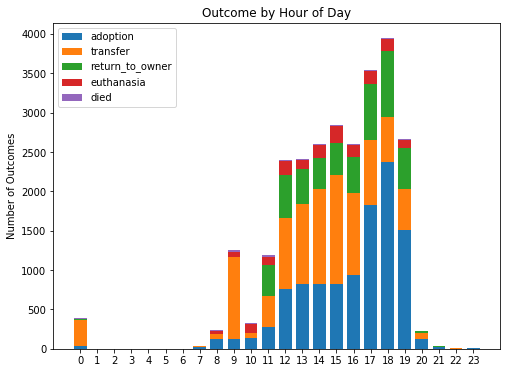

In [10]:
# Plot outcome by time of day

hourly_outcomes = train.groupby('Hour')['OutcomeType'].value_counts().unstack(0)
hourly_outcomes = hourly_outcomes.fillna(0)

fig, ax = plt.subplots(figsize=(8, 6))

ind = hourly_outcomes.columns
width = .75

adoption = hourly_outcomes.loc['Adoption'].values
died = hourly_outcomes.loc['Died'].values
euthanasia = hourly_outcomes.loc['Euthanasia'].values
return_to_owner = hourly_outcomes.loc['Return_to_owner'].values
transfer = hourly_outcomes.loc['Transfer'].values

ax.bar(ind, adoption, width)
ax.bar(ind, transfer, width, bottom = adoption)
ax.bar(ind, return_to_owner, width, bottom = adoption + transfer)
ax.bar(ind, euthanasia, width, bottom = adoption + transfer + return_to_owner)
ax.bar(ind, died, width, bottom = adoption + transfer + return_to_owner + euthanasia)
ax.legend(['adoption','transfer','return_to_owner','euthanasia','died'])
ax.set_title("Outcome by Hour of Day")
plt.ylabel('Number of Outcomes')
plt.xticks(range(24), ["%d" %i for i in range(0, 24)])

plt.show()

The data for midnight and 9am doesn't align with the surrounding times. Investigating further, we some unusual activity at 9a and midnight. Let's look into this further, there could be more information available. 

In [11]:
# Display entries for midnight and 9am
print(train[train['Hour'] == 0]['DateTime'].dt.strftime("%Y-%m-%d %H:%M:%S"))
print(train[train['Hour'] == 9]['DateTime'].dt.strftime("%Y-%m-%d %H:%M:%S"))

38       2015-08-11 00:00:00
117      2015-11-05 00:00:00
175      2015-09-01 00:00:00
181      2015-12-22 00:00:00
195      2015-09-01 00:00:00
248      2015-08-05 00:00:00
251      2016-02-07 00:00:00
289      2015-11-05 00:00:00
306      2015-11-23 00:00:00
409      2015-11-24 00:00:00
627      2016-02-07 00:00:00
644      2015-05-31 00:00:00
696      2015-11-24 00:00:00
769      2015-07-02 00:00:00
798      2015-08-11 00:00:00
816      2016-01-31 00:00:00
832      2016-02-15 00:00:00
896      2015-05-17 00:00:00
1039     2015-10-17 00:00:00
1084     2015-11-17 00:00:00
1087     2015-11-10 00:00:00
1172     2015-10-16 00:00:00
1213     2015-07-02 00:00:00
1295     2015-04-10 00:00:00
1313     2016-01-22 00:00:00
1406     2015-05-31 00:00:00
1411     2015-11-08 00:00:00
1551     2016-01-05 00:00:00
1640     2015-08-23 00:00:00
1757     2015-10-18 00:00:00
                ...         
24494    2015-01-12 00:00:00
24660    2015-07-04 00:00:00
24734    2016-01-31 00:00:00
24764    2015-

The vast majority of these entries are exactly on the hour, 0:00:00 or 9:00:00. Perhaps the staff is getting caught up on data entry for the day or night and those are the default values. Still, this could be valuable info if there's a clear pattern. Let's create a special OnTheHour feature to track this for all times.

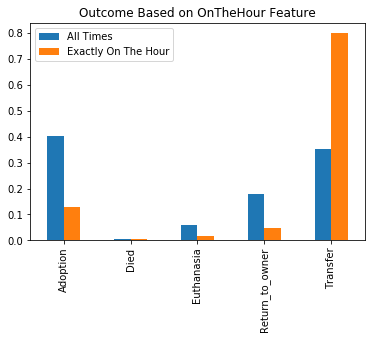

In [12]:
# Add 'OnTheHour' variable that tracks whether the time is exactly on the hour
train['OnTheHour'] = (train['DateTime'].dt.minute == 0) & (train['DateTime'].dt.second == 0).astype(int)
test['OnTheHour'] = (test['DateTime'].dt.minute == 0) & (test['DateTime'].dt.second == 0).astype(int)

all_times = train['OutcomeType'].value_counts(normalize=True)
on_the_hour = train[train['OnTheHour']==1]['OutcomeType'].value_counts(normalize=True)
comparison = pd.concat([all_times, on_the_hour], axis=1)
comparison.columns = ['All Times', 'Exactly On The Hour']

comparison.plot.bar(title = 'Outcome Based on OnTheHour Feature')

The plot compares entries with timestamps of X:00:00 vs all of the other normally varied times and shows that times exactly on the hour are much more likely to result in a transfer than anything else. Let's revisit the special cases of midnight and 9am.

In [13]:
# Display outcomes for 0:00:00 and 9:00:00 timestamps
print('Outcomes for 0:00:00: \n\n', train[(train['OnTheHour'] == 1) & (train['Hour'] == 0)]['OutcomeType'].value_counts(), '\n')
print('Outcomes for 9:00:00: \n\n', train[(train['OnTheHour'] == 1) & (train['Hour'] == 9)]['OutcomeType'].value_counts())


Outcomes for 0:00:00: 

 Transfer           311
Adoption            37
Return_to_owner     19
Died                 5
Euthanasia           3
Name: OutcomeType, dtype: int64 

Outcomes for 9:00:00: 

 Transfer    994
Died          1
Adoption      1
Name: OutcomeType, dtype: int64


Midnight entries are very likely to result in a transfer and 9am entries are almost certain to be a transfer. Let's move on to the sex of the animal and what effect that has on outcome.

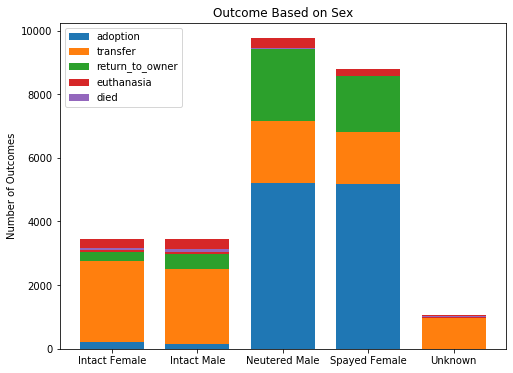

In [14]:
# Get data on sex of animal
sex_outcomes = train.groupby('SexuponOutcome')['OutcomeType'].value_counts().unstack(0)
sex_outcomes = sex_outcomes.fillna(0)

fig, ax = plt.subplots(figsize=(8, 6))

ind = sex_outcomes.columns
width = .75

adoption = sex_outcomes.loc['Adoption'].values
died = sex_outcomes.loc['Died'].values
euthanasia = sex_outcomes.loc['Euthanasia'].values
return_to_owner = sex_outcomes.loc['Return_to_owner'].values
transfer = sex_outcomes.loc['Transfer'].values

ax.bar(ind, adoption, width)
ax.bar(ind, transfer, width, bottom = adoption)
ax.bar(ind, return_to_owner, width, bottom = adoption + transfer)
ax.bar(ind, euthanasia, width, bottom = adoption + transfer + return_to_owner)
ax.bar(ind, died, width, bottom = adoption + transfer + return_to_owner + died)

# Plot
ax.legend(['adoption','transfer','return_to_owner','euthanasia','died'])
plt.title('Outcome Based on Sex')
plt.ylabel('Number of Outcomes')
plt.show()

Intact/unknown animals have much lower rates of adoption, understandably, as that is another hurdle for would be owners. Let's look into breed attributes and get a better idea of their usefulness.

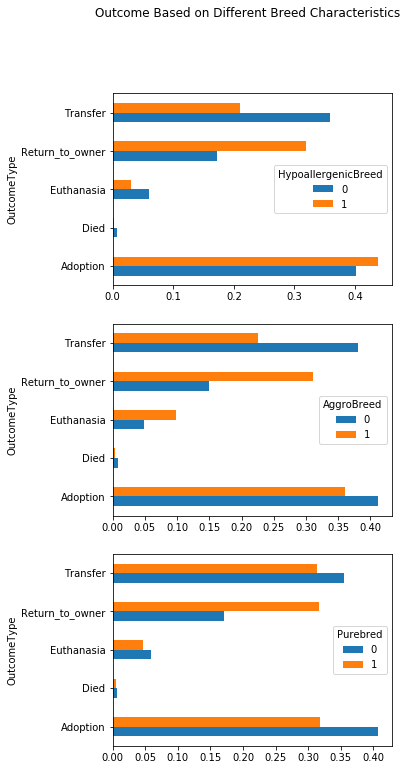

0    25627
1     1102
Name: HypoallergenicBreed, dtype: int64 

0    21930
1     4799
Name: AggroBreed, dtype: int64 

0    25338
1     1391
Name: Purebred, dtype: int64


In [15]:
# Plot various breed attributes
# normalize results to isolate the relative impact of the features
fig, ax = plt.subplots(3, 1, figsize=(5, 12))

train.groupby('HypoallergenicBreed')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.barh(ax = ax[0])
train.groupby('AggroBreed')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.barh(ax = ax[1])
train.groupby('Purebred')['OutcomeType'].value_counts(normalize=True).unstack(0).plot.barh(ax = ax[2])
fig.suptitle('Outcome Based on Different Breed Characteristics')
plt.show()

print(train['HypoallergenicBreed'].value_counts(),'\n')
print(train['AggroBreed'].value_counts(),'\n')
print(train['Purebred'].value_counts())

AggroBreed may be useful, there's enough variance in the outcomes, and unlike the other 2 features, the binary column isn't as lopsided towards 0.

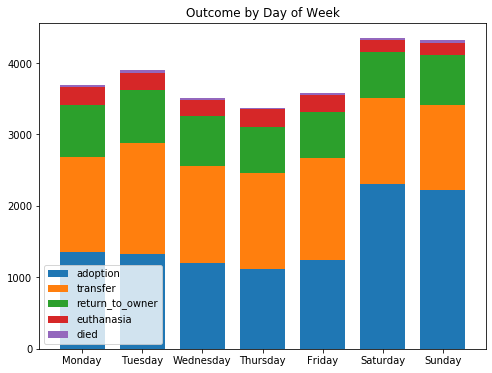

In [16]:
# Get outcomes for day of the week
day_outcomes = train.groupby('DayOfWeek')['OutcomeType'].value_counts().unstack(0)
day_outcomes = day_outcomes.fillna(0)

# Fix column order
day_outcomes = day_outcomes[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fig, ax = plt.subplots(figsize=(8, 6))

ind = day_outcomes.columns
width = .75

adoption = day_outcomes.loc['Adoption'].values
died = day_outcomes.loc['Died'].values
euthanasia = day_outcomes.loc['Euthanasia'].values
return_to_owner = day_outcomes.loc['Return_to_owner'].values
transfer = day_outcomes.loc['Transfer'].values

# Plot
ax.bar(ind, adoption, width)
ax.bar(ind, transfer, width, bottom = adoption)
ax.bar(ind, return_to_owner, width, bottom = adoption + transfer)
ax.bar(ind, euthanasia, width, bottom = adoption + transfer + return_to_owner)
ax.bar(ind, died, width, bottom = adoption + transfer + return_to_owner + euthanasia)
ax.legend(['adoption','transfer','return_to_owner','euthanasia','died'])
plt.xticks(range(7), ('Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.title('Outcome by Day of Week')
plt.show()


We see most of the day_of_week variation occurs between weekdays and weekends, so our model will probably do better by reducing cardinality to weekend or weekday.


In [17]:
# Extract weekend variable from DateTime
def is_weekend(df):
    df['weekend'] = df['DateTime'].dt.weekday.isin([5, 6]).astype(int)
    df = df.drop(columns=['DayOfWeek'])
    return df

train = is_weekend(train)
test = is_weekend(test)

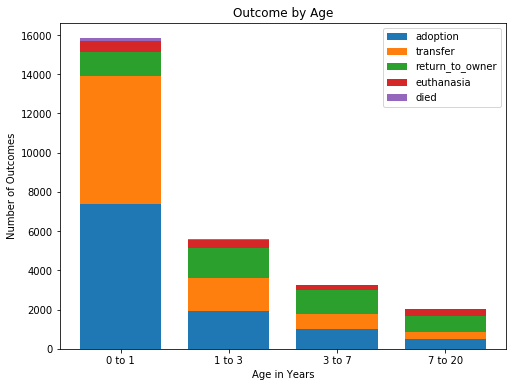

In [18]:
# Group outcome data by age
max_age = train['AgeuponOutcome'].max() / 365
bins = [0, 1, 3, 7, max_age]
train['binned_age'] = pd.cut(train['AgeuponOutcome'] / 365, bins)

age_outcomes = train.groupby('binned_age')['OutcomeType'].value_counts().unstack(0)

fig, ax = plt.subplots(figsize=(8, 6))

ind = ['0 to 1', '1 to 3', '3 to 7', '7 to 20']
width = .75

adoption = age_outcomes.loc['Adoption'].values
died = age_outcomes.loc['Died'].values
euthanasia = age_outcomes.loc['Euthanasia'].values
return_to_owner = age_outcomes.loc['Return_to_owner'].values
transfer = age_outcomes.loc['Transfer'].values

# Plot
ax.bar(ind, adoption, width)
ax.bar(ind, transfer, width, bottom = adoption)
ax.bar(ind, return_to_owner, width, bottom = adoption + transfer)
ax.bar(ind, euthanasia, width, bottom = adoption + transfer + return_to_owner)
ax.bar(ind, died, width, bottom = adoption + transfer + return_to_owner + euthanasia)
ax.legend(['adoption','transfer','return_to_owner','euthanasia','died'])

plt.title('Outcome by Age')
plt.xlabel('Age in Years')
plt.ylabel('Number of Outcomes')
plt.show()

The vast majority of animals are puppies and kittens. There's enough variance here that age should provide some predictive power.

# Build Classifier

In [19]:
# Feature selection

y_train = train['OutcomeType']

X_train = train[['HasName','AgeuponOutcome', 'AggroBreed','HourSin', 'HourCos', 'OnTheHour', 'Dog', 'Male', 'Intact', 'SexUnknown', 'weekend']]

X_test = test[['HasName','AgeuponOutcome', 'AggroBreed','HourSin', 'HourCos', 'OnTheHour', 'Dog', 'Male', 'Intact', 'SexUnknown', 'weekend']]


In [20]:
# Define the model
xgb_model = XGBClassifier(random_state = 42, n_estimators = 45)

# Fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=45, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

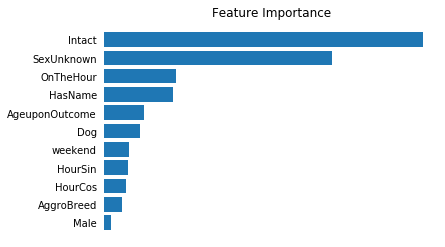

In [21]:
# Inspect feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type="gain")

feature_importance = sorted(feature_importance.items(), key=lambda x: x[1])

feature = list(zip(*feature_importance))[0]
score = list(zip(*feature_importance))[1]
y_pos = np.arange(len(feature)) 

plt.barh(y_pos, score, align='center')
plt.yticks(y_pos, feature) 
plt.title('Feature Importance')
plt.box(False)
plt.tick_params(left = False, bottom = False, labelbottom = False)
plt.show()

Intactness is a very strong predictor, along with the SexUnknown feature, which is clear from the previous plot based on sex. We also see that our manufactured OnTheHour feature is confirmed as another good indicator, while the binary Male feature, AggroBreed, and two time features are among the less helpful. We can now make our final predictions.

In [22]:
# Get predictions
xgb_pred = xgb_model.predict_proba(X_test) 

# Export to csv for submission
results = pd.DataFrame(xgb_pred, columns = xgb_model.classes_, index = test['ID']).reset_index()
results.to_csv('submission.csv', index=False)